In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#!pwd

In [3]:
#import os
#os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [4]:

#!kaggle datasets download -d shivam2503/diamonds

In [5]:
!pip install scikit-learn;

!pip install seaborn;

!pip install ipympl;

You should consider upgrading via the '/Users/dacarpen/.pyenv/versions/3.6.14/bin/python3.6 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/dacarpen/.pyenv/versions/3.6.14/bin/python3.6 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/dacarpen/.pyenv/versions/3.6.14/bin/python3.6 -m pip install --upgrade pip' command.


In [6]:

%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from numpy import mean
from numpy import std
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import MDS
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MeanShift
from sklearn.cluster import OPTICS
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer

read in our dataset

In [7]:
#diamonds = pd.read_csv("data/diamonds.csv");
#c1 = pd.read_csv("data/Cam_college_stats/Cam_stats_2015.csv");
#c2= pd.read_csv("data/Cam_college_stats/Cam_stats_2016.csv");
#c3= pd.read_csv("data/Cam_college_stats/Cam_stats_2017.csv");
#c4=pd.read_csv("data/Cam_college_stats/Cam_stats_2018.csv");
#c5 = pd.read_csv("data/Cam_college_stats/Cam_stats_2019.csv");
#cam_college = pd.concat([c1,c2,c3,c4,c5])
#weatherAUS = pd.read_csv("data/weatherAUS.csv")
housing = pd.read_csv("data/housing.csv")

dataset = housing

In [8]:
dataset.shape

(511, 14)

we will work with a sample of the data  if there are too many datapoints. The full dataset may exceed the capabilities of this notebook's memory, and the random selection aspect of sample will help ensure a represenative set of samples

In [9]:
sampledData = dataset if dataset.shape[0] <= 1000 else dataset.sample(frac=(1000/dataset.shape[0]))

Preview of the data

In [10]:

sampledData[:5]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


Next we want to indentify all string columns, and encode them. This uses OneHotEncoder, but more domain knowledge of the dataset may be able to select some better encodings; for instance, some of the categories may be best mapped to a single int for each category, since they are all on a scale. This preproc will be used in our subsequent pipelines.

Other types of data should be normalized - adjusted to a mean of 0 and scaled to the same basic range. This makes the different components much more comparable and amiable to further analysis.

In [11]:
cat_cols = sampledData[:1].select_dtypes(include='object').columns.values
remainderProcessor = Pipeline(steps = [('scale', preprocessing.StandardScaler()), ('impute', SimpleImputer(missing_values=np.nan, strategy='mean'))])
preproc = ColumnTransformer(transformers=[('onehot', OneHotEncoder( sparse=False), cat_cols)],
                            remainder=remainderProcessor)

# Principle Component Analysis
Principle component analysis can help us view the inherent dimensionality of the data. Oftentimes the dimensionality of our data is much higher than it really needs to be to adequately explain it, and this analysis helps us determine it. 

Note that the category properties each count as a dimension per property with the one hot encoding, so this reduction may yield a higher dimension space than we started with. 

In [12]:
steps = [('encode', preproc), ('pca', PCA(n_components = 'mle'))]
modelPCA = Pipeline(steps=steps)

In [13]:
 dataPCA = modelPCA.fit_transform(sampledData)

In [14]:
 dataPCA.shape[1]

13

# MDS 
multi dimensional scaling tries to map the data down to a lower number of dimensions while respecting the distances of the data as much as possible. We are scaling it down to 3 dimensions, so a location+color graph can show the resultant shape

In [15]:
steps = [('encode', preproc), ('mds', MDS(n_components=3))]
modelMds = Pipeline(steps=steps)
diamondsMds = modelMds.fit_transform(sampledData)

In [16]:
diamondsMds.shape

(511, 3)

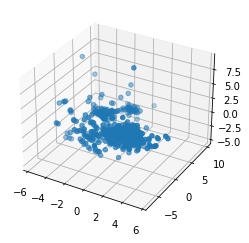

In [17]:
fig = plt.figure();
ax = plt.axes(projection='3d')
ax.scatter3D(diamondsMds[:,0], diamondsMds[:,1], diamondsMds[:,2])

# Clustering
We can then cluster the data to see if there are obvious groupings within it. 



In [18]:
steps = [
    ('encode', preproc),
    ('optics', OPTICS(cluster_method='dbscan', eps=1.75)),]
modelOpticsDB = Pipeline(steps=steps)

steps = [
    ('encode', preproc),
    ('optics', OPTICS(cluster_method='xi'))]
modelOpticsXI = Pipeline(steps=steps)



In [19]:
opticsClusterDB = modelOpticsDB.fit_predict(sampledData)
opticsClusterXI = modelOpticsXI.fit_predict(sampledData)

Lets see how many clusters we found

In [20]:
numClustersOpticsDB = np.unique(modelOpticsDB.named_steps['optics'].labels_).size
numClustersOpticsDB



10

In [21]:
numClustersOpticsXI = np.unique(modelOpticsXI.named_steps['optics'].labels_).size
numClustersOpticsXI

17

In [22]:
sum(modelOpticsXI.named_steps['optics'].labels_ == -1)

365

# Visualized Clusters
We can combine MDS with clustering to show where the clusters lie in terms of the MDS. Since we will need color for showing clusters, this will be a 3D MDS. Note that the clustering is done in the original space and is only being displayed with reduced dimensionality, so the clusters may not correspond visually with the data.

In [23]:


labels = modelOpticsDB.named_steps['optics'].labels_


In [24]:
space = np.arange(len(sampledData))
clust = modelOpticsXI.named_steps['optics']
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]


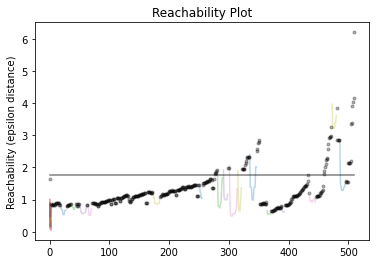

In [25]:
plt.figure()
ax1 = plt.axes();
colorPalette = sns.color_palette(None, numClustersOpticsXI);

for klass, color in zip(range(0, numClustersOpticsXI), colorPalette):
    Xk = space[labels == klass];
    Rk = reachability[labels == klass];
    ax1.plot(Xk, Rk, color, alpha=0.3);
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3);
ax1.plot(space, np.full_like(space, 1.75, dtype=float), "k-", alpha=0.5);
#ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5);
ax1.set_ylabel("Reachability (epsilon distance)");
ax1.set_title("Reachability Plot");

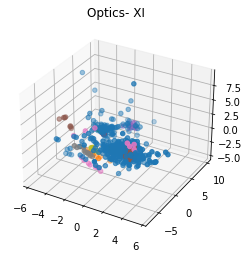

In [26]:
newcmp = ListedColormap(colorPalette)
fig = plt.figure();
ax = plt.axes(projection='3d')
labels = modelOpticsXI.named_steps['optics'].labels_
ax.scatter3D(diamondsMds[:,0], diamondsMds[:,1], diamondsMds[:,2], c=labels, cmap=newcmp)
ax.set_title("Optics- XI");
# pd.DataFrame(diamondsMdsClusters).plot.scatter(0, 1, c=labels, colormap=newcmp)

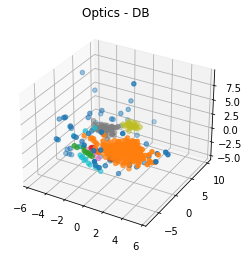

In [27]:
newcmp = ListedColormap(sns.color_palette(None, numClustersOpticsDB))
fig = plt.figure();
ax = plt.axes(projection='3d')
labels = modelOpticsDB.named_steps['optics'].labels_
ax.scatter3D(diamondsMds[:,0], diamondsMds[:,1], diamondsMds[:,2], c=labels, cmap=newcmp)
ax.set_title("Optics - DB");

# Outlier Detection
Another Thing to do is try to identify outliers in the data. 

In [28]:
steps = [
    ('encode', preproc),
    ('outlier', IsolationForest())]
modelOutlier = Pipeline(steps=steps)

In [29]:
outlierScores = modelOutlier.fit_predict(sampledData)

First we can see how many outliers we detected

In [30]:
sum(outlierScores == -1)

70

Then we can graph them on the same dimensionality reduction plot as before

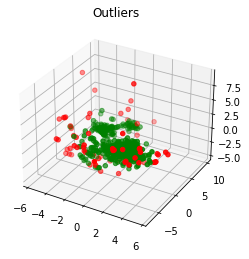

In [31]:

newcmp = ListedColormap(['green', 'black', 'red'])
labels = 2-(outlierScores + 1)
fig = plt.figure();
ax = plt.axes(projection='3d')
ax.scatter3D(diamondsMds[:,0], diamondsMds[:,1], diamondsMds[:,2], c=labels, cmap=newcmp)
ax.set_title("Outliers");

We can also just get a list of those outliers and do things with it directly. For instance, we can look at those values. WE could also try filtering out the outliers and re-running the other analysises to see if underlying patterns become more apparent.  

In [32]:
outliers = sampledData[outlierScores == -1]

In [33]:
outliers[:5]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
54,0.01360,75.0,4.00,0,0.410,5.888,47.6,7.3197,3,469,21.1,396.90,14.80,18.9
55,0.01311,90.0,1.22,0,0.403,7.249,21.9,8.6966,5,226,17.9,395.93,4.81,35.4
57,0.01432,100.0,1.32,0,0.411,6.816,40.5,8.3248,5,256,15.1,392.90,3.95,31.6
126,0.38735,0.0,25.65,0,0.581,5.613,95.6,1.7572,2,188,19.1,359.29,27.26,15.7
141,1.62864,0.0,21.89,0,0.624,5.019,100.0,1.4394,4,437,21.2,396.90,34.41,14.4


# Clusters without outliers

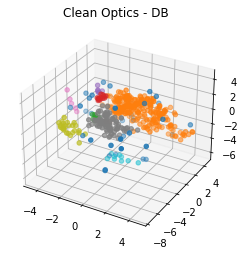

In [34]:
cleanData = sampledData[outlierScores != -1]
cleanOpticsCluster = modelOpticsDB.fit_predict(cleanData)
cleanMdsClusters = modelMds.fit_transform(cleanData)

labels = modelOpticsDB.named_steps['optics'].labels_
numClustersOpticsDB = np.unique(modelOpticsDB.named_steps['optics'].labels_).size

newcmp = ListedColormap(sns.color_palette(None, numClustersOpticsDB))
fig = plt.figure();
ax = plt.axes(projection='3d')
labels = modelOpticsDB.named_steps['optics'].labels_
ax.scatter3D(cleanMdsClusters[:,0], cleanMdsClusters[:,1], cleanMdsClusters[:,2], c=labels, cmap=newcmp)
ax.set_title("Clean Optics - DB");
